In [2]:
import gdown
import glob
import folium
import pandas as pd
import os
import numpy as np
import datetime 
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import *

**Load Mean Temperature Data For Stations.**

In [3]:
temp_filename = 'https://raw.githubusercontent.com/ielattar/Climate-Change/main/data/mean_temp.csv'
temp_df = pd.read_csv(temp_filename,engine='python').reset_index()
temp_df.drop(temp_df.columns[[1]], axis=1, inplace=True)
temp_df=temp_df.replace(-9999.9, np.nan)
temp_df=temp_df.dropna(axis=0, subset=['mean-temp(celsius)'])
temp_df.head(5)

,index,year,mean-temp(celsius),stnid,Station name,Prov,%Miss,Lat(deg),Long(deg),Elev(m),Joined,RCS
1,1,1914,4.1,1012010,COWICHAN_BAY_CHERRY_,BC,7.7,48.7,-123.5,0,n,n
2,2,1915,3.7,1012010,COWICHAN_BAY_CHERRY_,BC,7.7,48.7,-123.5,0,n,n
3,3,1916,1.2,1012010,COWICHAN_BAY_CHERRY_,BC,7.7,48.7,-123.5,0,n,n
4,4,1917,2.1,1012010,COWICHAN_BAY_CHERRY_,BC,7.7,48.7,-123.5,0,n,n
5,5,1918,3.7,1012010,COWICHAN_BAY_CHERRY_,BC,7.7,48.7,-123.5,0,n,n


**Find the Three Top Most Stations with highest record count by Province.**

In [4]:
temp_df_count=temp_df.groupby(['Prov','Station name']).size().sort_values(ascending=False).reset_index(name='count') 
sample_stations_df=temp_df_count.groupby('Prov').head(3)

**Filter The Mean Temperature Data Frame to only include the readings of the top stations.**

In [5]:
names_list = sample_stations_df['Station name'].values.tolist() 
name_list_str=','.join(names_list)
#print(name_list_str)
filtered_temp_df = temp_df[temp_df['Station name'].isin(names_list)]
filtered_temp_df.head(5)

,index,year,mean-temp(celsius),stnid,Station name,Prov,%Miss,Lat(deg),Long(deg),Elev(m),Joined,RCS
637,637,1899,2.4,1018621,VICTORIA,BC,0.3,48.6,-123.4,2,y,n
638,638,1900,4.5,1018621,VICTORIA,BC,0.3,48.6,-123.4,2,y,n
639,639,1901,4.1,1018621,VICTORIA,BC,0.3,48.6,-123.4,2,y,n
640,640,1902,4.5,1018621,VICTORIA,BC,0.3,48.6,-123.4,2,y,n
641,641,1903,3.5,1018621,VICTORIA,BC,0.3,48.6,-123.4,2,y,n


**Create a 2D scatterplot with an overlaid regression line For temperature over time per Province**

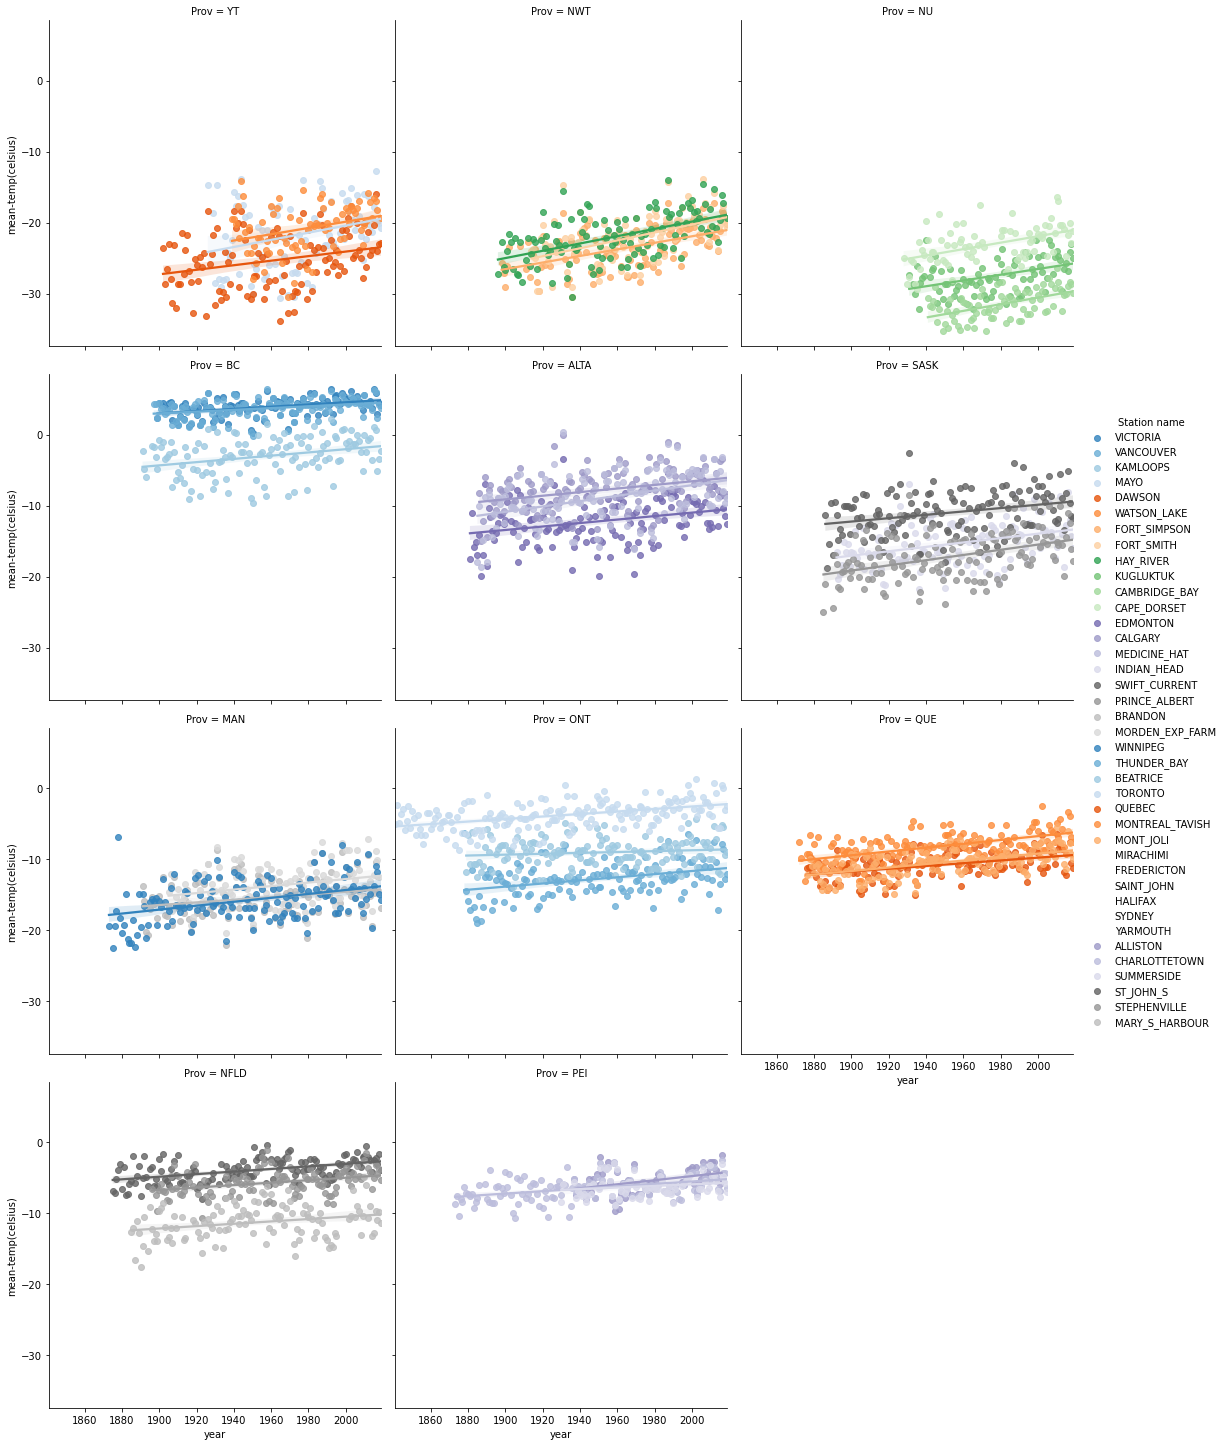

In [6]:
chart=sns.lmplot(
            x='year',
            y='mean-temp(celsius)',
            data=filtered_temp_df,
            col='Prov',
            hue='Station name',
            legend_out=True,
            palette="tab20c",
            col_wrap=3,
            col_order=["YT","NWT","NU","BC","ALTA","SASK","MAN","ONT","QUE","NFLD","PEI"]
        )
plt.show()

**Ceate a 2D line plot showing temperature trends over time per Province**

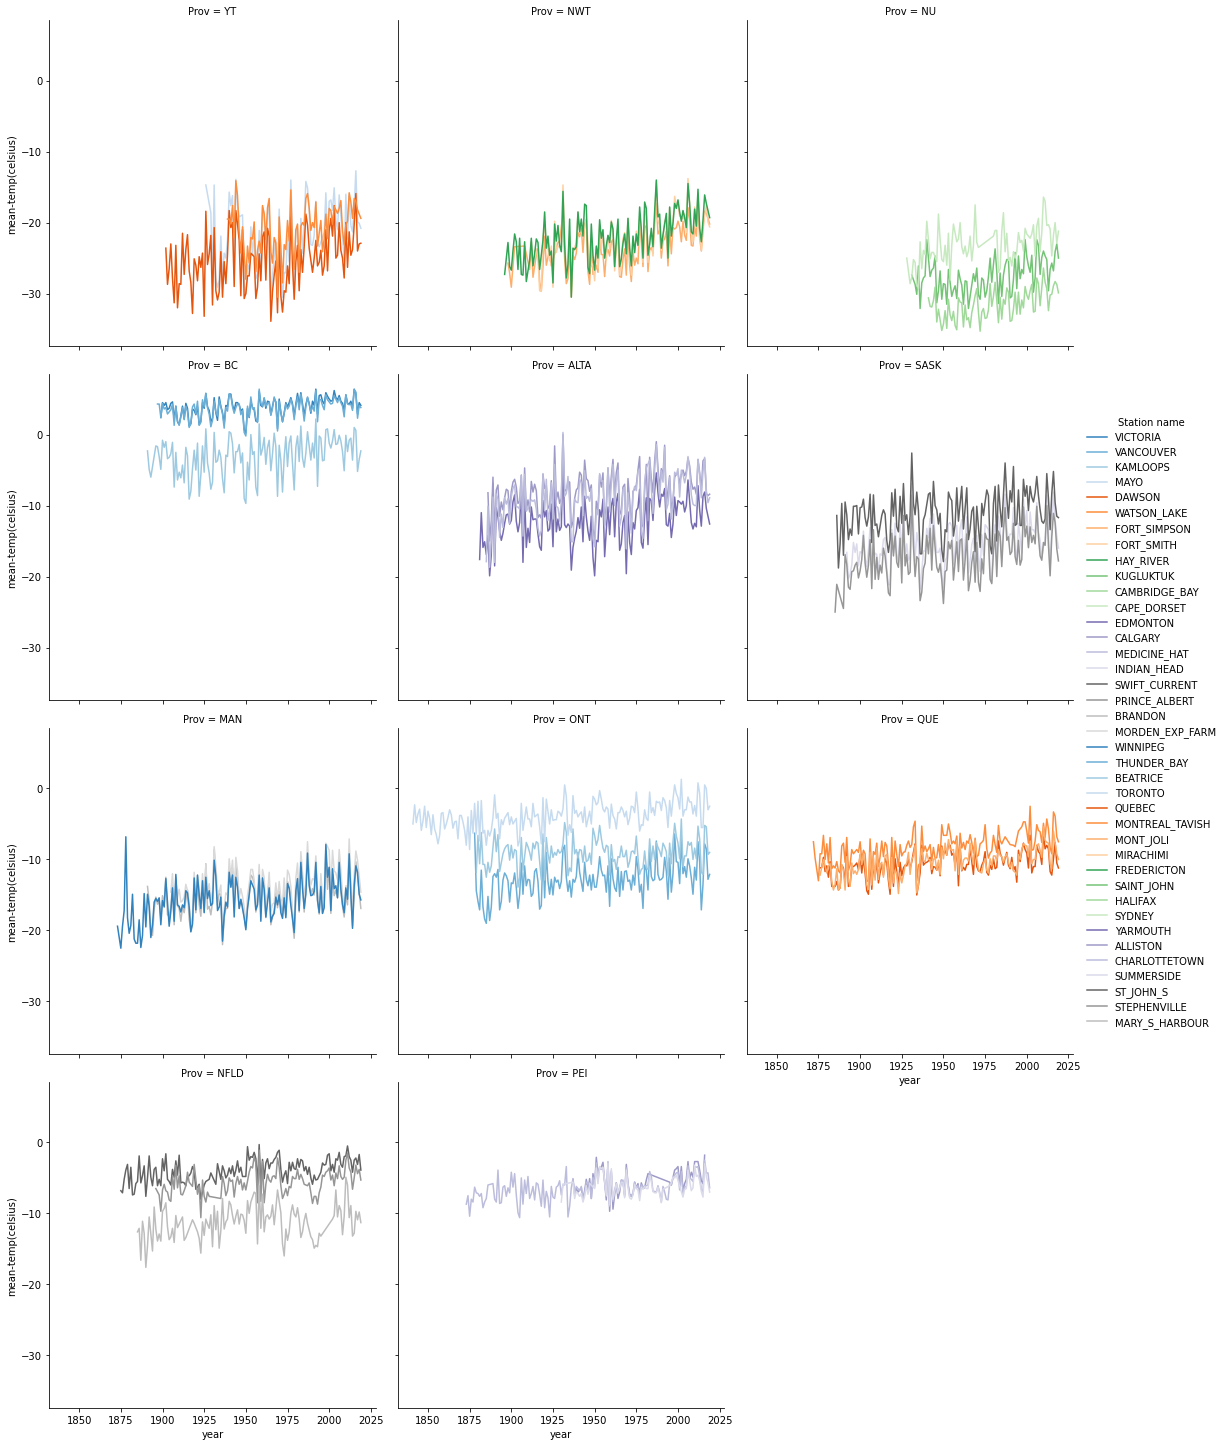

In [7]:
chart=sns.relplot(
            x='year',
            y='mean-temp(celsius)',
            data=filtered_temp_df,
            col='Prov',
            hue='Station name',
            kind="line",
            palette="tab20c",
            col_wrap=3,
            col_order=["YT","NWT","NU","BC","ALTA","SASK","MAN","ONT","QUE","NFLD","PEI"]
        )
plt.show()

**Fetch a sample station per  province for resampling by decade**

In [8]:
stations_df=filtered_temp_df.groupby('Prov').apply(lambda df: df.sample(1))
names_list = stations_df['Station name'].values.tolist() 
name_list_str=','.join(names_list)
sampled_stations_df = filtered_temp_df[filtered_temp_df['Station name'].isin(names_list)]
sampled_stations_df= sampled_stations_df[['year','Station name','mean-temp(celsius)']]


**Loop through stations and resample by decade**

<AxesSubplot:xlabel='year', ylabel='station name'>

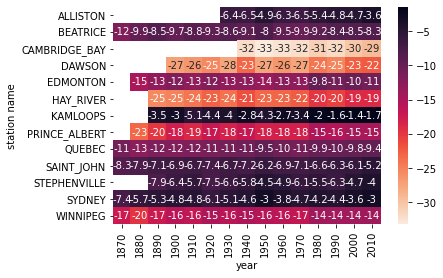

In [40]:
resampled_data = []
stations_list = sampled_stations_df['Station name'].unique().tolist() 
for aStation in stations_list:
    queryString="`Station name`=='"+ aStation + "'"
    station_temp_df=sampled_stations_df.query(queryString)
    station_temp_df= station_temp_df[['year','mean-temp(celsius)']]
    station_temp_df=station_temp_df.set_index('year')
    station_temp_df.index=pd.to_datetime(station_temp_df.index,format='%Y')
    station_decade_df=station_temp_df.groupby(station_temp_df.index.year // 10 * 10).mean()
    #station_decade_df=station_temp_df.resample('10AS').mean()
    #sns.lineplot(data=station_decade_df, x="year", y="mean-temp(celsius)")
    station_decade_df['station name'] = aStation 
    #print(station_decade_df)
    #station_decade_df=station_decade_df.dropna()
    resampled_data.append(station_decade_df)
resampled_temp_df = pd.concat(resampled_data)
resampled_temp_df.reset_index()
cmap = sns.cm.rocket_r
pivoted_df=resampled_temp_df.pivot_table(index='station name', columns='year', values='mean-temp(celsius)')
sns.heatmap(pivoted_df,annot=True,cmap = cmap)


        